# Projet 4 : Notebook de prédiction sur la consommation totale d'énergie de bâtiments non résidentiels à Seattle

In [1]:
package_list = ['pandas', 'numpy', 'matplotlib', 'scikit-learn']

In [2]:
!python3 -V

Python 3.9.13


In [3]:
txt = !python3 -m pip freeze
check = lambda i : any([(pack in i) for pack in package_list])
txt = [i for i in txt if check (i)]
txt

['matplotlib @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_757ijfo2tl/croots/recipe/matplotlib-suite_1660167932741/work',
 'matplotlib-inline @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9ddl71oqte/croots/recipe/matplotlib-inline_1662014471815/work',
 'numpy @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_10c245a1-1c81-453c-8b70-3e944787a8d9mo1xhesu/croots/recipe/numpy_and_numpy_base_1653915529188/work',
 'numpydoc @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_753dae38-7ca3-4e28-bd02-7f92dc5dac540wd4kft3/croots/recipe/numpydoc_1657529877062/work',
 'pandas==1.4.4',
 'scikit-learn @ file:///opt/concourse/worker/volumes/live/cffa5efe-beec-4a37-5774-350794e43990/volume/scikit-learn_1642617139916/work',
 'scikit-learn-intelex==2021.20221004.121333']

# 1. Imports

In [4]:
#builtin
import os, warnings

#data
import pandas as pd
import numpy as np

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#metrics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Modélisation :
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor

from sklearn import neighbors

from sklearn.ensemble import GradientBoostingRegressor #pour gradient boosting
from sklearn import tree 

from sklearn import svm



#model selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV



#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Graphics and options

In [5]:
#désactive les warnings
warnings.filterwarnings(action = 'once')

# 3. Data

In [6]:
df = pd.read_csv("df_cleaned.csv")
df.head()

,OSEBuildingID,PropertyName,Latitude,Longitude,PrimaryPropertyType,Neighborhood,NumberOfYearsSinceConstruction,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,energy_source
0,1,Mayflower park hotel,47.61220,-122.33799,Hotel,DOWNTOWN,96,1.0,12,0,60.0,7226362.5,249.98,Electricity & Gaz
1,2,Paramount Hotel,47.61317,-122.33393,Hotel,DOWNTOWN,27,1.0,11,15064,61.0,8387933.0,295.86,Electricity & Gaz
2,3,5673-The Westin Seattle,47.61393,-122.33810,Hotel,DOWNTOWN,54,1.0,41,196718,43.0,72587024.0,2089.28,Electricity & Gaz
3,5,HOTEL MAX,47.61412,-122.33664,Hotel,DOWNTOWN,97,1.0,10,0,56.0,6794584.0,286.43,Electricity & Gaz
4,8,WARWICK SEATTLE HOTEL (ID8),47.61375,-122.34047,Hotel,DOWNTOWN,43,1.0,18,62000,75.0,14172606.0,505.01,Electricity & Gaz


In [7]:
df.shape

(1443, 14)

# 4. Data preparation

## 4.0 Rename "nom_colonne_target" in "target"


In [8]:
df = df.rename(columns = {"SiteEnergyUse(kBtu)" : "target1"})
df = df.rename(columns = {"TotalGHGEmissions" : "target2"})

df.head()

,OSEBuildingID,PropertyName,Latitude,Longitude,PrimaryPropertyType,Neighborhood,NumberOfYearsSinceConstruction,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,target1,target2,energy_source
0,1,Mayflower park hotel,47.61220,-122.33799,Hotel,DOWNTOWN,96,1.0,12,0,60.0,7226362.5,249.98,Electricity & Gaz
1,2,Paramount Hotel,47.61317,-122.33393,Hotel,DOWNTOWN,27,1.0,11,15064,61.0,8387933.0,295.86,Electricity & Gaz
2,3,5673-The Westin Seattle,47.61393,-122.33810,Hotel,DOWNTOWN,54,1.0,41,196718,43.0,72587024.0,2089.28,Electricity & Gaz
3,5,HOTEL MAX,47.61412,-122.33664,Hotel,DOWNTOWN,97,1.0,10,0,56.0,6794584.0,286.43,Electricity & Gaz
4,8,WARWICK SEATTLE HOTEL (ID8),47.61375,-122.34047,Hotel,DOWNTOWN,43,1.0,18,62000,75.0,14172606.0,505.01,Electricity & Gaz


In [9]:
df.isna().sum()

OSEBuildingID                       0
PropertyName                        0
Latitude                            0
Longitude                           0
PrimaryPropertyType                 0
Neighborhood                        0
NumberOfYearsSinceConstruction      0
NumberofBuildings                   0
NumberofFloors                      0
PropertyGFAParking                  0
ENERGYSTARScore                   458
target1                             0
target2                             0
energy_source                       0
dtype: int64

## 4.1 X et y

In [10]:
#target1 est la consommation totale d'énergie
#target2 est la quantité d'émission de CO2

#Sélection colonnes pour modélisation:
X = df[["PrimaryPropertyType", "Neighborhood", "NumberOfYearsSinceConstruction", "NumberofBuildings", "NumberofFloors", "PropertyGFAParking", "ENERGYSTARScore", 'energy_source']] 
y = df.target1

In [11]:
X.head()

,PrimaryPropertyType,Neighborhood,NumberOfYearsSinceConstruction,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,energy_source
0,Hotel,DOWNTOWN,96,1.0,12,0,60.0,Electricity & Gaz
1,Hotel,DOWNTOWN,27,1.0,11,15064,61.0,Electricity & Gaz
2,Hotel,DOWNTOWN,54,1.0,41,196718,43.0,Electricity & Gaz
3,Hotel,DOWNTOWN,97,1.0,10,0,56.0,Electricity & Gaz
4,Hotel,DOWNTOWN,43,1.0,18,62000,75.0,Electricity & Gaz


In [12]:
y.head()

0     7226362.5
1     8387933.0
2    72587024.0
3     6794584.0
4    14172606.0
Name: target1, dtype: float64

## 4.2 Train Test split

In [13]:
#Séparons le jeu de données en données d'entraînement et de test,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [14]:
X_train

,PrimaryPropertyType,Neighborhood,NumberOfYearsSinceConstruction,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,energy_source
1182,Small- and Mid-Sized Office,LAKE UNION,15,1.0,4,0,45.0,Gaz
1096,Medical Office,DELRIDGE,53,1.0,1,0,89.0,Electricity & Gaz
438,Retail Store,DOWNTOWN,113,1.0,6,0,89.0,Electricity & Gaz
506,Supermarket / Grocery Store,GREATER DUWAMISH,60,1.0,1,0,57.0,Electricity & Gaz
880,Small- and Mid-Sized Office,MAGNOLIA / QUEEN ANNE,15,1.0,4,8399,89.0,Gaz
...,...,...,...,...,...,...,...,...
763,Other,EAST,59,1.0,4,0,NaN,Electricity & Gaz
835,Senior Care Community,NORTHWEST,69,1.0,2,0,85.0,Electricity & Gaz
1216,Mixed Use Property,DOWNTOWN,14,1.0,19,201857,87.0,Electricity & Gaz
559,Small- and Mid-Sized Office,BALLARD,44,1.0,3,0,46.0,Electricity & Gaz


In [15]:
X_test

,PrimaryPropertyType,Neighborhood,NumberOfYearsSinceConstruction,NumberofBuildings,NumberofFloors,PropertyGFAParking,ENERGYSTARScore,energy_source
1098,Warehouse,DELRIDGE,41,1.0,2,0,80.0,Gaz
477,Small- and Mid-Sized Office,DOWNTOWN,114,1.0,6,0,57.0,Gaz
184,Retail Store,SOUTHEAST,43,1.0,2,0,80.0,Electricity & Gaz
302,Distribution Center,GREATER DUWAMISH,56,1.0,1,0,62.0,Electricity & Gaz
981,Small- and Mid-Sized Office,GREATER DUWAMISH,40,1.0,2,0,20.0,Gaz
...,...,...,...,...,...,...,...,...
1355,Warehouse,GREATER DUWAMISH,58,1.0,1,0,65.0,Gaz
1382,Supermarket / Grocery Store,NORTH,12,1.0,1,0,74.0,Electricity & Gaz
644,Hotel,DOWNTOWN,114,1.0,6,0,94.0,Electricity & Gaz
1292,Mixed Use Property,EAST,35,1.0,2,0,NaN,Electricity & Gaz


In [16]:
y_train

1182    3.168131e+06
1096    3.133850e+06
438     3.241917e+06
506     7.439009e+06
880     1.294615e+06
            ...     
763     8.476183e+06
835     5.655578e+06
1216    2.768448e+07
559     3.220635e+06
684     3.615421e+05
Name: target1, Length: 1010, dtype: float64

In [17]:
y_test

1098    3.084004e+05
477     2.886142e+06
184     1.168860e+07
302     5.464762e+06
981     1.435563e+06
            ...     
1355    4.859710e+05
1382    1.170296e+07
644     3.321603e+06
1292    2.735812e+06
418     1.602064e+07
Name: target1, Length: 433, dtype: float64

# 5. Modélisation avec pipeline

## 5.1 Pipeline simple

In [18]:
# Recognizing the categorical columns and numerical columns :
cols_cat = ["PrimaryPropertyType", "Neighborhood", 'energy_source']
cols_num = ["NumberOfYearsSinceConstruction", "NumberofBuildings", "NumberofFloors", 
            "PropertyGFAParking", "ENERGYSTARScore"]



# Preprocessing for categorical data :
ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

# Preprocessing for numerical data :
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()


#Models :
estimator = DummyRegressor()
lr = linear_model.LinearRegression()
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
rfr = RandomForestRegressor()
knn = neighbors.KNeighborsRegressor()
gbt = GradientBoostingRegressor()
svr = svm.SVR()

In [19]:
# Make Transformer


preprocessing = make_column_transformer(
                                (make_pipeline(imputer,scaler), cols_num),
                                (ohe, cols_cat),
                                remainder='passthrough')

In [20]:
# Make pipelines
pipe_est = make_pipeline(preprocessing, estimator)
pipe_lr = make_pipeline(preprocessing, lr)
pipe_ridge = make_pipeline(preprocessing, ridge)
pipe_lasso = make_pipeline(preprocessing, lasso)
pipe_rfr = make_pipeline(preprocessing, rfr)
pipe_knn = make_pipeline(preprocessing, knn)
pipe_gbt = make_pipeline(preprocessing, gbt)
pipe_svr = make_pipeline(preprocessing, svr)

In [21]:
# Fit model
pipe_est.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_ridge.fit(X_train, y_train)
pipe_lasso.fit(X_train, y_train)
pipe_rfr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_gbt.fit(X_train, y_train)
pipe_svr.fit(X_train, y_train)


#Score sur données train :
score_est_train = pipe_est.score(X_train, y_train)
score_lr_train = pipe_lr.score(X_train, y_train)
score_ridge_train = pipe_ridge.score(X_train, y_train)
score_lasso_train = pipe_lasso.score(X_train, y_train)
score_rfr_train = pipe_rfr.score(X_train, y_train)
score_knn_train = pipe_knn.score(X_train, y_train)
score_gbt_train = pipe_gbt.score(X_train, y_train)
score_svr_train = pipe_svr.score(X_train, y_train)


#Score sur données test :
score_est_test = pipe_est.score(X_test, y_test)
score_lr_test = pipe_lr.score(X_test, y_test)
score_ridge_test = pipe_ridge.score(X_test, y_test)
score_lasso_test = pipe_lasso.score(X_test, y_test)
score_rfr_test = pipe_rfr.score(X_test, y_test)
score_knn_test = pipe_knn.score(X_test, y_test)
score_gbt_test = pipe_gbt.score(X_test, y_test)
score_svr_test = pipe_svr.score(X_test, y_test)




tableau = pd.DataFrame()
tableau ["Modèle utilisé"] = ["Dummy Regressor median", "Régression baseline", 
                              "Ridge", "Lasso", "Random Forest", "K-NN", 
                              "Gradient Boosting", "SVR"]
tableau ["R2-score données train"] = [score_est_train, 
                                     score_lr_train, 
                                     score_ridge_train,
                                     score_lasso_train,
                                     score_rfr_train,
                                     score_knn_train,
                                     score_gbt_train,
                                     score_svr_train
                                     ]
tableau ["R2-score données test"] = [score_est_test, 
                                     score_lr_test, 
                                     score_ridge_test,
                                     score_lasso_test,
                                     score_rfr_test,
                                     score_knn_test,
                                     score_gbt_test,
                                     score_svr_test
                                    ]




/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3129795981650224e+16, tolerance: 37645411892391.83
  model = cd_fast.sparse_enet_coordinate_descent(


In [22]:
display(tableau)

,Modèle utilisé,R2-score données train,R2-score données test
0,Dummy Regressor median,0.000000,-0.000012
1,Régression baseline,0.621560,0.343379
2,Ridge,0.617908,0.348782
3,Lasso,0.621560,0.343219
4,Random Forest,0.934906,0.326142
5,K-NN,0.637795,0.400880
6,Gradient Boosting,0.900752,0.336454
7,SVR,-0.071688,-0.074006


## 5.2 Pipeline avec GridSearchCV : détermination des meilleurs hyper paramètres et du meilleur modèle

## 5.2.1 DummyRegressor

In [23]:
#GridSearch:

# Set params for Grid Search
param_grid_est = {'dummyregressor__strategy': ['mean', 'median']}

In [24]:
# Run grid search
pipe_est2 = make_pipeline(preprocessing, estimator)

grid_est = GridSearchCV(pipe_est2, param_grid_est, cv=5, scoring = 'r2', refit=True)
grid_est.fit(X_train,y_train)
print(grid_est.best_params_)
print(grid_est.score(X_train, y_train))
print(grid_est.score(X_test, y_test))

{'dummyregressor__strategy': 'mean'}
0.0
-1.2169245913629112e-05


## 5.2.2 Regression baseline

In [25]:
#GridSearch:

# Set params for Grid Search
param_grid_lr = {'linearregression__fit_intercept' : [True, False],
                 'linearregression__n_jobs' : [None, -1]}

In [26]:
# Run grid search
pipe_lr2 = make_pipeline(preprocessing, lr)

grid_lr = GridSearchCV(pipe_lr2, param_grid_lr, cv=5, scoring = 'r2', refit=True)
grid_lr.fit(X_train,y_train)
print(grid_lr.best_params_)
print(grid_lr.score(X_train, y_train))
print(grid_lr.score(X_test, y_test))

{'linearregression__fit_intercept': False, 'linearregression__n_jobs': None}
0.6215598062433321
0.34197588477722174


### 5.2.1 Ridge

In [27]:
#GridSearch:

# Set params for Grid Search
param_grid_ridge = {'ridge__alpha': [0,0.5,1]}



In [28]:
# Run grid search
pipe_ridge2 = make_pipeline(preprocessing, ridge)

grid_ridge = GridSearchCV(pipe_ridge2, param_grid_ridge, cv=5, scoring = 'r2', refit=True)
grid_ridge.fit(X_train,y_train)
print(grid_ridge.best_params_)
print(grid_ridge.score(X_train, y_train))
print(grid_ridge.score(X_test, y_test))

{'ridge__alpha': 0.5}
0.6204581724132694
0.3465231086731665


### 5.2.2 Lasso

In [29]:
#GridSearch:

# Set params for Grid Search
param_grid_lasso = {'lasso__alpha': [0,0.5,1]}

In [30]:
# Run grid search
pipe_lasso2 = make_pipeline(preprocessing, lasso)

grid_lasso = GridSearchCV(pipe_lasso2, param_grid_lasso, cv=5, scoring = 'r2', refit=True)
grid_lasso.fit(X_train,y_train)
print(grid_lasso.best_params_)
print(grid_lasso.score(X_train, y_train))
print(grid_lasso.score(X_test, y_test))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.412609587767562e+16, tolerance: 26598540377331.293
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

{'lasso__alpha': 1}
0.6215598066024838
0.34321926754611864


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3129795981650224e+16, tolerance: 37645411892391.83
  model = cd_fast.sparse_enet_coordinate_descent(


### 5.2.3 Random Forest

In [31]:
#GridSearch:
# Set params for Grid Search
param_grid_rfr = {'randomforestregressor__n_estimators': [100,110,120,150],
                 'randomforestregressor__random_state': [0,42],
                 'randomforestregressor__max_features':  [5,7,10]}

In [32]:
# Run grid search
pipe_rfr2 = make_pipeline(preprocessing, rfr)

grid_rfr = GridSearchCV(pipe_rfr2, param_grid_rfr, cv=5, scoring = 'r2', refit=True)
grid_rfr.fit(X_train,y_train)
print(grid_rfr.best_params_)
print(grid_rfr.score(X_train, y_train))
print(grid_rfr.score(X_test, y_test))

{'randomforestregressor__max_features': 7, 'randomforestregressor__n_estimators': 120, 'randomforestregressor__random_state': 0}
0.9397078388099316
0.40807720090593746


### 5.2.4 K-NN

In [33]:
#GridSearch:

# Set params for Grid Search
param_grid_knn = {'kneighborsregressor__n_neighbors' : list(range(1,31)),
                 'kneighborsregressor__weights': ['uniform', 'distance']
                 }


In [34]:
# Run grid search
pipe_knn2 = make_pipeline(preprocessing, knn)


grid_knn = GridSearchCV(pipe_knn2, param_grid_knn, cv=10, scoring = 'r2', refit=True)
grid_knn.fit(X_train,y_train)
print(grid_knn.best_params_)
print(grid_knn.score(X_train, y_train))
print(grid_knn.score(X_test, y_test))





{'kneighborsregressor__n_neighbors': 25, 'kneighborsregressor__weights': 'distance'}
0.9999426121937434
0.35067877109295176


### 5.2.5 Gradient Boosting

In [35]:
#GridSearch:
#'squared_error' = 'ls'
#'absolute_error' = 'lad'
# Set params for Grid Search
param_grid_gbt = {'gradientboostingregressor__learning_rate' : [0.086,0.087,0.088, 0.09],
                  'gradientboostingregressor__max_depth': [4,5,6,7 ],
                 'gradientboostingregressor__random_state': [0,42],
                 'gradientboostingregressor__max_features': [5,6,7]
                 }

In [36]:
# Run grid search
pipe_gbt2 = make_pipeline(preprocessing, gbt)


grid_gbt = GridSearchCV(pipe_gbt2, param_grid_gbt, cv=10, scoring = 'r2', refit=True)
grid_gbt.fit(X_train,y_train)
print(grid_gbt.best_params_)
print(grid_gbt.score(X_train, y_train))
print(grid_gbt.score(X_test, y_test))

{'gradientboostingregressor__learning_rate': 0.086, 'gradientboostingregressor__max_depth': 7, 'gradientboostingregressor__max_features': 6, 'gradientboostingregressor__random_state': 42}
0.9727898067902896
0.4238001819013978


### 5.2.6 SVR

In [37]:
#GridSearch:
# Set params for Grid Search
param_grid_svr = {'svr__kernel' : ('linear', 'rbf','poly'),
                  'svr__C' : [1.5, 10],
                  'svr__gamma' : [1e-7, 1e-4],
                  'svr__epsilon' : [0.1,0.2,0.5,0.3]
                 }

In [38]:
# Run grid search
pipe_svr2 = make_pipeline(preprocessing, svr)


grid_svr = GridSearchCV(pipe_svr2, param_grid_svr, cv=10, scoring = 'r2', refit=True)
grid_svr.fit(X_train,y_train)
print(grid_svr.best_params_)
print(grid_svr.score(X_train, y_train))
print(grid_svr.score(X_test, y_test))

{'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 1e-07, 'svr__kernel': 'linear'}
-0.07132728672585076
-0.0735438463939293


### 5.2.7 Tableau récapitulatif

In [39]:
tableau_grid = pd.DataFrame()
tableau_grid ["Modèle utilisé avec gridsearch"] = ["Dummy Regressor", "Régression baseline", "Ridge", "Lasso", "Random Forest", "K-NN", "Gradient Boosting", "SVR"]
tableau_grid ["Hyper paramètres"] = [grid_est.best_params_,
                                     grid_lr.best_params_,
                                     grid_ridge.best_params_,
                                     grid_lasso.best_params_,
                                     grid_rfr.best_params_,
                                     grid_knn.best_params_,
                                     grid_gbt.best_params_,
                                     grid_svr.best_params_
                                    ]
tableau_grid ["R2-score données train"] = [grid_est.score(X_train, y_train),
                                           grid_lr.score(X_train, y_train),
                                           grid_ridge.score(X_train, y_train),
                                           grid_lasso.score(X_train, y_train),
                                           grid_rfr.score(X_train, y_train),
                                           grid_knn.score(X_train, y_train),
                                           grid_gbt.score(X_train, y_train),
                                           grid_svr.score(X_train, y_train)
                                          ]
tableau_grid ["R2-score données test"] = [grid_est.score(X_test, y_test),
                                          grid_lr.score(X_test, y_test),
                                          grid_ridge.score(X_test, y_test),
                                          grid_lasso.score(X_test, y_test),
                                          grid_rfr.score(X_test, y_test),
                                          grid_knn.score(X_test, y_test),
                                          grid_gbt.score(X_test, y_test),
                                          grid_svr.score(X_test, y_test)
                                         ]
pd.options.display.max_rows = 128
pd.options.display.max_columns = 128
display(tableau_grid)


,Modèle utilisé avec gridsearch,Hyper paramètres,R2-score données train,R2-score données test
0,Dummy Regressor,{'dummyregressor__strategy': 'mean'},0.000000,-0.000012
1,Régression baseline,"{'linearregression__fit_intercept': False, 'li...",0.621560,0.341976
2,Ridge,{'ridge__alpha': 0.5},0.620458,0.346523
3,Lasso,{'lasso__alpha': 1},0.621560,0.343219
4,Random Forest,"{'randomforestregressor__max_features': 7, 'ra...",0.939708,0.408077
5,K-NN,"{'kneighborsregressor__n_neighbors': 25, 'knei...",0.999943,0.350679
6,Gradient Boosting,{'gradientboostingregressor__learning_rate': 0...,0.972790,0.423800
7,SVR,"{'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamm...",-0.071327,-0.073544


# K-NN est en overfitting. Le meilleur modèle est Gradient Boosting, on le stocke dans une variable : model_gbt

# 6. Performance des validations croisées pour le meilleur modèle : Gradient Boosting

In [40]:
model_gbt = grid_gbt.best_estimator_

In [41]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print("Pour le Gradient Boosting : ",grid_gbt.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
tableau_cross_gbt = pd.DataFrame(grid_gbt.cv_results_)
tableau_cross_gbt = tableau_cross_gbt[['mean_test_score', 'std_test_score', 'param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__max_depth', 'param_gradientboostingregressor__max_features', 'param_gradientboostingregressor__random_state' ]]
tableau_cross_gbt.rename(columns={ 'param_gradientboostingregressor__learning_rate':'param_gbt__learning_rate', 'param_gradientboostingregressor__max_depth':'param_gbt__max_depth', 'param_gradientboostingregressor__max_features' : 'param_gbt__max_features', 'param_gradientboostingregressor__random_state' : 'param_gbt__random_state' })

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
Pour le Gradient Boosting :  {'gradientboostingregressor__learning_rate': 0.086, 'gradientboostingregressor__max_depth': 7, 'gradientboostingregressor__max_features': 6, 'gradientboostingregressor__random_state': 42}
Résultats de la validation croisée :


,mean_test_score,std_test_score,param_gbt__learning_rate,param_gbt__max_depth,param_gbt__max_features,param_gbt__random_state
0,0.196031,0.740505,0.086,4,5,0
1,0.242458,0.730313,0.086,4,5,42
2,0.228552,0.788802,0.086,4,6,0
3,0.270883,0.533537,0.086,4,6,42
4,0.247276,0.633687,0.086,4,7,0
5,0.156181,0.953493,0.086,4,7,42
6,0.167648,0.726739,0.086,5,5,0
7,0.264776,0.642374,0.086,5,5,42
8,0.291310,0.596902,0.086,5,6,0
9,0.309816,0.484283,0.086,5,6,42


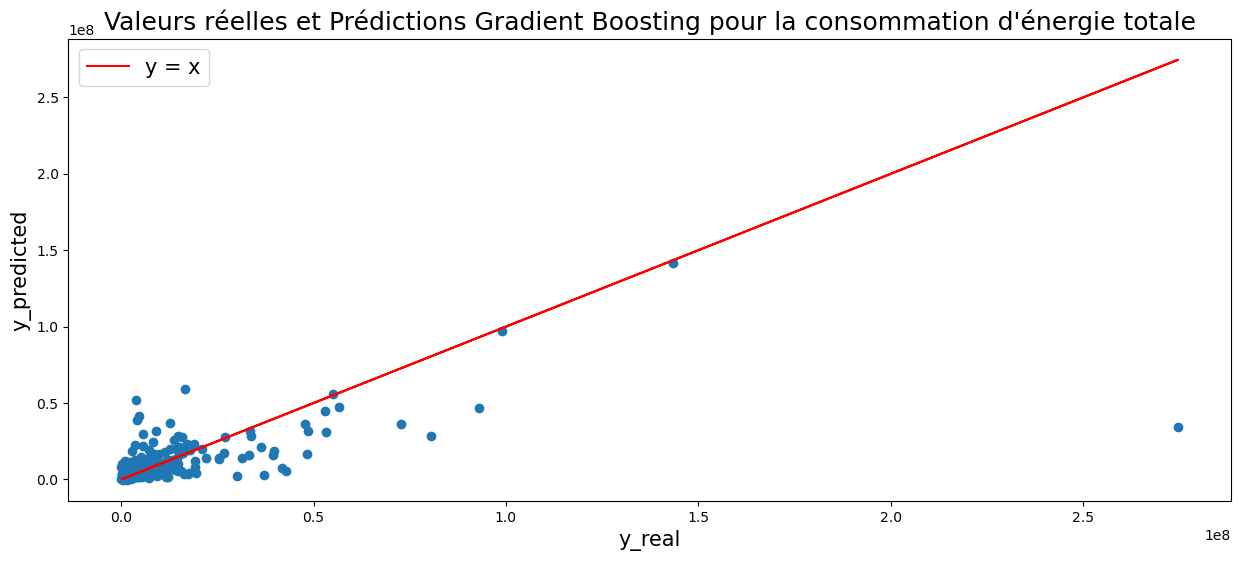

In [42]:
# Defining the real values for target feature
y_real = y_test

# Calculating predictions on testing set
y_predicted = model_gbt.predict(X_test)

# Setting parameters of the plot
fig = plt.figure(figsize=(15, 6))
plt.title("Valeurs réelles et Prédictions Gradient Boosting pour la consommation d'énergie totale", fontsize = 18)
plt.xlabel('y_real', fontsize=15)
plt.ylabel('y_predicted', fontsize=15)

# Plotting the scatter plot
plt.scatter(y_test, y_predicted)

# Plotting the x=y line
plot = plt.plot(y_real, y_real, color='red', label = 'y = x')
plt.legend(fontsize = 15)
plt.show()

# 7. Features importance pour évaluer l'importance de la variable ENERGYSTARScore

In [43]:
#Récupération noms colonnes :

onehot_columns = model_gbt['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out(input_features=cols_cat)
onehot_columns = list(onehot_columns)
onehot_columns

['PrimaryPropertyType_Distribution Center',
 'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K-12 School',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_Large Office',
 'PrimaryPropertyType_Low-Rise Multifamily',
 'PrimaryPropertyType_Medical Office',
 'PrimaryPropertyType_Mixed Use Property',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_Refrigerated Warehouse',
 'PrimaryPropertyType_Residence Hall',
 'PrimaryPropertyType_Restaurant',
 'PrimaryPropertyType_Retail Store',
 'PrimaryPropertyType_Self-Storage Facility',
 'PrimaryPropertyType_Senior Care Community',
 'PrimaryPropertyType_Small- and Mid-Sized Office',
 'PrimaryPropertyType_Supermarket / Grocery Store',
 'PrimaryPropertyType_University',
 'PrimaryPropertyType_Warehouse',
 'PrimaryPropertyType_Worship Facility',
 'Neighborhood_BALLARD',
 'Neighborhood_Ballard',
 'Neighborhood_CENTRAL',
 'Neighborhood_Central',
 'Neighborhood_DELRIDGE',
 'Neighborhood_DOWNTOWN',
 'Neighborho

In [44]:
cols_num

['NumberOfYearsSinceConstruction',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'ENERGYSTARScore']

In [45]:
feature_names = []
feature_names = cols_num + onehot_columns

In [46]:
#Importance de chaque feature :
feature_importance = model_gbt['gradientboostingregressor'].feature_importances_


importance_df = pd.DataFrame({'features': feature_names,
                              'importance': feature_importance})

importance_df

,features,importance
0,NumberOfYearsSinceConstruction,7.182996e-02
1,NumberofBuildings,2.724276e-01
2,NumberofFloors,1.339270e-01
3,PropertyGFAParking,5.588236e-02
4,ENERGYSTARScore,6.381342e-02
5,PrimaryPropertyType_Distribution Center,4.919829e-04
6,PrimaryPropertyType_Hospital,2.311837e-01
7,PrimaryPropertyType_Hotel,4.227206e-03
8,PrimaryPropertyType_K-12 School,1.204994e-03
9,PrimaryPropertyType_Laboratory,1.393787e-03


In [47]:
#Regroupement des features onehotencodées :

#Sélection des features :
var_PrimaryPropertyType = ['PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory', 'PrimaryPropertyType_Large Office', 'PrimaryPropertyType_Low-Rise Multifamily', 'PrimaryPropertyType_Medical Office', 'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Refrigerated Warehouse', 'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store', 'PrimaryPropertyType_Self-Storage Facility', 'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Small- and Mid-Sized Office', 'PrimaryPropertyType_Supermarket / Grocery Store', 'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse', 'PrimaryPropertyType_Worship Facility']
var_Neighborhood = ['Neighborhood_BALLARD', 'Neighborhood_Ballard', 'Neighborhood_CENTRAL', 'Neighborhood_Central', 'Neighborhood_DELRIDGE', 'Neighborhood_DOWNTOWN', 'Neighborhood_Delridge', 'Neighborhood_EAST', 'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION', 'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH', 'Neighborhood_NORTHEAST', 'Neighborhood_NORTHWEST', 'Neighborhood_North', 'Neighborhood_Northwest', 'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']
var_energy_source = ['energy_source_Electricity & Gaz', 'energy_source_Gaz', 'energy_source_Source non connue']


#Calcul de la somme des importances :
importance_PrimaryPropertyType = importance_df[importance_df.features.isin(var_PrimaryPropertyType)]['importance'].sum()

importance_Neighborhood = importance_df[importance_df.features.isin(var_Neighborhood)]['importance'].sum()

importance_energy_source = importance_df[importance_df.features.isin(var_energy_source)]['importance'].sum()


#Création de lignes supplémentaires et suppression des anciennes lignes :
df_sup = pd.DataFrame([['PrimaryPropertyType', importance_PrimaryPropertyType], ['Neighborhood', importance_Neighborhood], ['energy_source',importance_energy_source ]], columns = ['features', 'importance'])
    
                      
importance_df = pd.concat([importance_df, df_sup], ignore_index = True)
importance_df
list_importance_features = ['NumberOfYearsSinceConstruction','NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'ENERGYSTARScore','PrimaryPropertyType','Neighborhood', 'energy_source']
importance_df = importance_df[importance_df.features.isin(list_importance_features)]
importance_df.sort_values(by = 'importance', ascending = False, ignore_index=True, inplace = True)
display(importance_df)
print(importance_df['importance'].sum().round(4))

,features,importance
0,PrimaryPropertyType,0.293129
1,NumberofBuildings,0.272428
2,NumberofFloors,0.133927
3,Neighborhood,0.083701
4,NumberOfYearsSinceConstruction,0.071830
5,ENERGYSTARScore,0.063813
6,PropertyGFAParking,0.055882
7,energy_source,0.025290


1.0


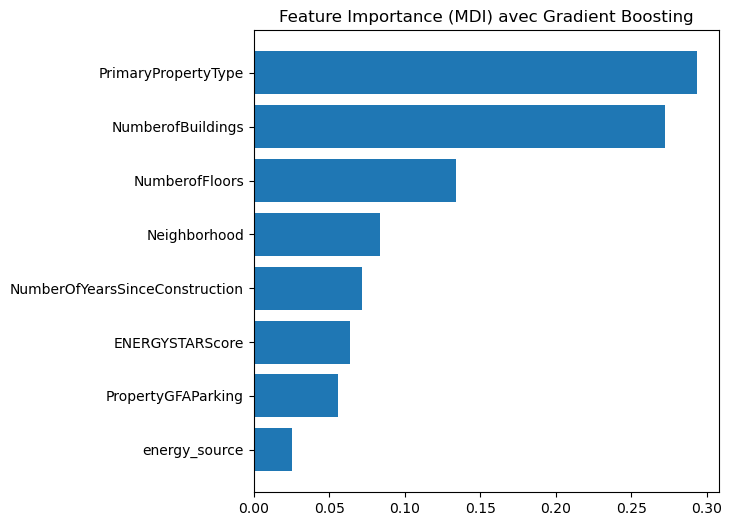

In [48]:
#Features importance graphic :

#
# Get Feature importance data using feature_importances_ attribute
#
importance_df.sort_values(by = 'importance', ignore_index=True, inplace = True)
feature_importance = importance_df['importance']
list_feature_name = importance_df['features']

pos = np.arange(importance_df.shape[0]) + .5

fig = plt.figure(figsize=(6, 6))
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, list_feature_name)
plt.title('Feature Importance (MDI) avec Gradient Boosting')
plt.show()

# On observe que la variable ENERGYSTARScore influe très peu sur le calcul de la consommation d'énergie totale. Par contre le type d'usage du bâtiment et le nombre de buildings/étages sont très influents.